In [ ]:
!wget https://raw.githubusercontent.com/pSzyc/Ising/main/Model/input_pipeline.py

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import csv
from pathlib import Path
import sys
import pandas as pd
import seaborn as sns
import glob
import contextlib
from PIL import Image
from google.colab import drive
plt.rcParams['figure.dpi'] = 300

drive.mount('/content/drive', force_remount=True)
drive_path = Path("drive/MyDrive/Licencjat")
data_path = drive_path / "data"

Mounted at /content/drive


# Model

In [ ]:
class CVAE(tf.keras.Model):
  """Variational autoencoder."""

  def __init__(self, latent_dim, num_classes,  kernel_size = 3):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(32, (kernel_size, kernel_size), activation='relu', padding="same", input_shape=(32, 32, 1)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Conv2D(64, (kernel_size, kernel_size), padding="same", activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Conv2D(64, (kernel_size, kernel_size), padding="same", activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(latent_dim + latent_dim)
          ]
     )

    self.decoder = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim+num_classes,)),
          tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
          tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=kernel_size,strides=(1, 1),padding="SAME",activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.UpSampling2D(size=(2, 2)),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=kernel_size,strides=(1, 1),padding="SAME",activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.UpSampling2D(size=(2, 2)),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=kernel_size,strides=(1, 1),padding="SAME",activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=kernel_size, strides=(1, 1), padding="SAME"),
        ]
    )

  def call(self, inputs):
    image, temp = inputs
    mean, logvar = self.encode(image)
    z = self.reparameterize(mean, logvar)
    z = tf.concat([z, temp], axis=1)
    reconstructed = self.decode(z)
    return reconstructed

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  image, temp = x
  mean, logvar = model.encode(image)
  z = model.reparameterize(mean, logvar)
  z_t = tf.concat([z, temp], axis=1)
  x_logit = model.decode(z_t)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=image)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Training

In [ ]:
def plot_spins(path, predictions, originals):
    fig = plt.figure(figsize=(15, 20))
    subfigs = fig.subfigures(nrows=len(predictions), ncols=1)
    images, temps = originals
    for index, subfig in enumerate(subfigs):
        subfig.suptitle(f'Sample nr: {index}')
        axs = subfig.subplots(nrows=1, ncols=4)

        axs[0].imshow(predictions[index, :, :, 0], vmin=0, vmax=1)
        axs[0].axis('off')
        axs[0].set_title("Spin +1 probability map")

        axs[1].imshow(np.random.binomial(1, predictions[index, :, :, 0]), vmin=0, vmax=1)
        axs[1].axis('off')
        axs[1].set_title("Predicted from binomial")

        axs[2].imshow(predictions[index, :, :, 0] > 0.5, vmin=0, vmax=1)
        axs[2].axis('off')
        axs[2].set_title("p > 0.5")

        axs[3].imshow(images[index, :, :, 0], vmin=0, vmax=1)
        axs[3].axis('off')
        axs[3].set_title("Original Sample")

    plt.savefig(path)
    plt.show()

def generate_and_save_images(model, epoch, test_sample, results):
  predictions = make_prediction(model, test_sample)
  plot_spins(results / "Images" / f'image_at_epoch_{epoch}.png', predictions, test_sample)

def make_prediction(model, test_sample):
    images, temps = test_sample
    mean, logvar = model.encode(images)
    z = model.reparameterize(mean, logvar)
    z = tf.concat([z, temps], axis=1)
    predictions = model.sample(z)
    return predictions

def cost_function_plot(loss_list, results):
  plt.figure()
  plt.suptitle("Loss function vs Epoch - CVAE")
  plt.plot(loss_list)
  plt.xlabel("Epoch")
  plt.ylabel("Cost function")
  plt.savefig(results / "loss_function.png")


# Dataset

In [ ]:
class DataIterator:
    def __init__(self, datasets):
        self.datasets = datasets

    def __iter__(self):
        self.data_iterators = [iter(data) for data in self.datasets]
        return self

    def __next__(self):
        data_list = []
        temp_list = []
        for index, data_iterator in enumerate(self.data_iterators):
            data = next(data_iterator)
            data_list.append(data)
            temp = np.zeros((data.shape[0], len(self.data_iterators)))
            temp[:, index] = 1
            temp_list.append(temp)
        temps = tf.concat(temp_list, axis=0)
        data = tf.concat(data_list, axis=0)
        return data, temps

In [ ]:
import tensorflow as tf
from input_pipeline import dataset_tfrecord_pipeline
from pathlib import Path

def make_dataset(data_dir, temps, batch_size=100, flatten=False):
    if isinstance(data_dir, str):
        data_dir = Path(data_dir)

    assert batch_size % len(temps) == 0, "Batch size must be divisible by the number of temperatures"

    trainset = []
    testset = []
    for temp in temps:
        dataset = dataset_tfrecord_pipeline(data_dir / f"Data{temp:.1f}.tfrecord", flatten=flatten, batch_size=batch_size // len(temps))
        trainset.append(dataset)
        dataset = dataset_tfrecord_pipeline(data_dir / f"TestData{temp:.1f}.tfrecord", flatten=flatten, batch_size=batch_size // len(temps))
        testset.append(dataset)

    gen_test = DataIterator(testset, temps)
    test_dataset = tf.data.Dataset.from_generator(lambda: gen_test, output_signature = (tf.TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32), tf.TensorSpec(shape=(None, len(temps)), dtype=tf.float32)))
    gen_train = DataIterator(trainset, temps)
    train_dataset = tf.data.Dataset.from_generator(lambda: gen_train, output_signature = (tf.TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32), tf.TensorSpec(shape=(None, len(temps)), dtype=tf.float32)))
    return train_dataset, test_dataset

In [ ]:
def load_starting_weights(model):
    dummy_image = tf.zeros((1, 32, 32, 1))
    dummy_temp = tf.zeros(shape = (1, 11), dtype = tf.float32)
    dummy_input = (dummy_image, dummy_temp)
    model(dummy_input)
    model.load_weights(drive_path / "Results" / "cvae" / "reference" / "cvae.h5")

In [ ]:
from IPython import display
from time import time
from queue import Queue
from input_pipeline import dataset_tfrecord_pipeline
from datetime import datetime

def train(temps, batch_size = 100, epochs = 50, latent_dim = 200, num_examples_to_generate = 5, test_size = 50, dataset = None):
  # Folders for storing the results and dataset
  current_datetime = datetime.now()
  formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M")
  results = drive_path / "Results" / "cvae" / formatted_datetime
  results.mkdir()
  (results / "Images").mkdir()

  # Model and optimizer
  optimizer = tf.keras.optimizers.Adam(1e-4)
  model = CVAE(latent_dim, len(temps))
  loss_monitor = 3 * [False]

  # Dataset
  if dataset is None:
    load_starting_weights(model)
    trainset = cvae_dataset(data_path, temps, batch_size = batch_size)
    testset = cvae_dataset(data_path / "test", temps, batch_size = batch_size)
  else:
    trainset, testset = dataset

  # Test sample for image generation
  assert batch_size >= num_examples_to_generate
  for image, temps in testset.take(1):
    image_sample = image[0:num_examples_to_generate, :, :, :]
    temp_sample = temps[0:num_examples_to_generate, :]
    test_sample = (image_sample, temp_sample)
  generate_and_save_images(model, 0, test_sample, results)

  # Training loop
  loss_list = []
  for epoch in range(1, epochs + 1):
    time_start = time()
    for train_x in trainset:
      train_step(model, train_x, optimizer)
    loss = tf.keras.metrics.Mean()
    for test_x in testset:
      loss(compute_loss(model, test_x))

    elbo = -loss.result()
    loss_list.append(loss.result().numpy())

    if epoch > 1:
      loss_monitor.pop(-1)
      loss_monitor.insert(0, loss_list[-1] - loss_list[-2] > 0)
      if all(loss_monitor):
        print("STOP!")
        break

    display.clear_output(wait=False)
    generate_and_save_images(model, epoch, test_sample, results)
    elapsed = time() - time_start
    print(f'Epoch: {epoch}, Test set ELBO: {elbo}, Time needed: {elapsed}')

  cost_function_plot(loss_list, results)
  model.save_weights(results / f'cvae.h5',save_format='h5')

## Train

In [ ]:
temps = [t for t in np.arange(2.0, 3.1, 0.1)]
epochs = 10
latent_dim = 200
num_examples_to_generate = 5
batch_size = 110

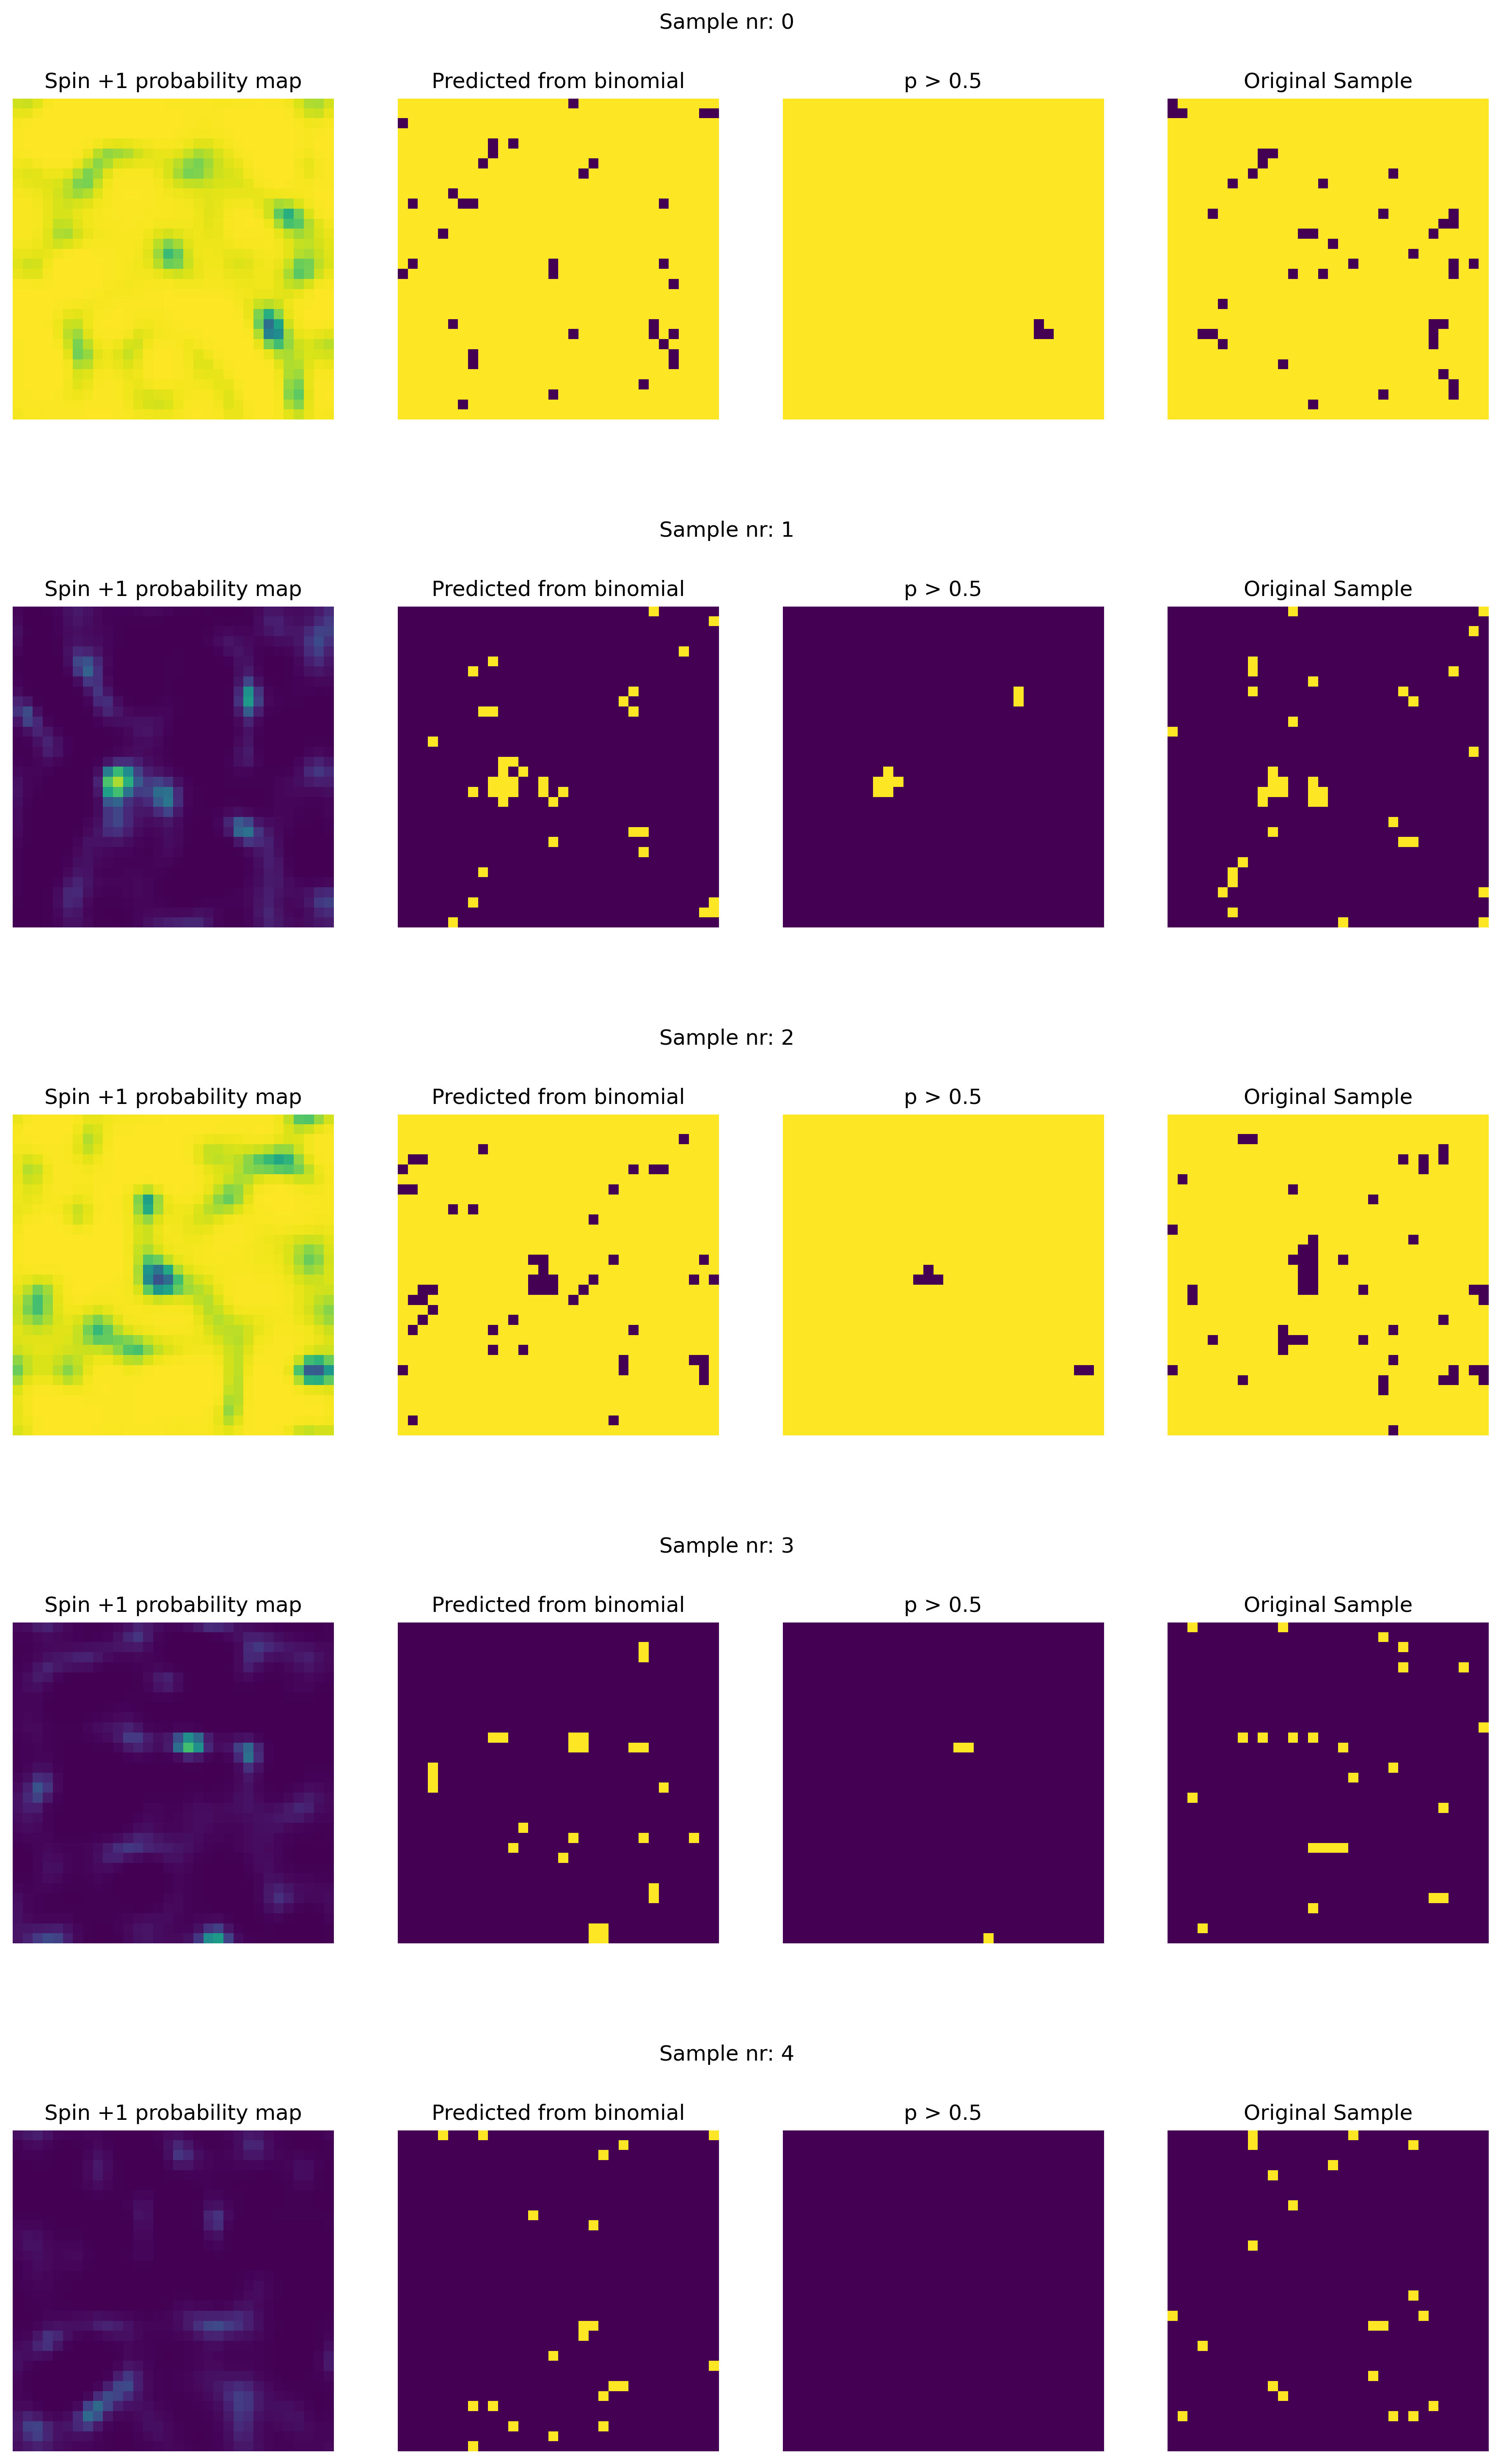

Epoch: 10, Test set ELBO: -428.4359130859375, Time needed: 238.75262880325317


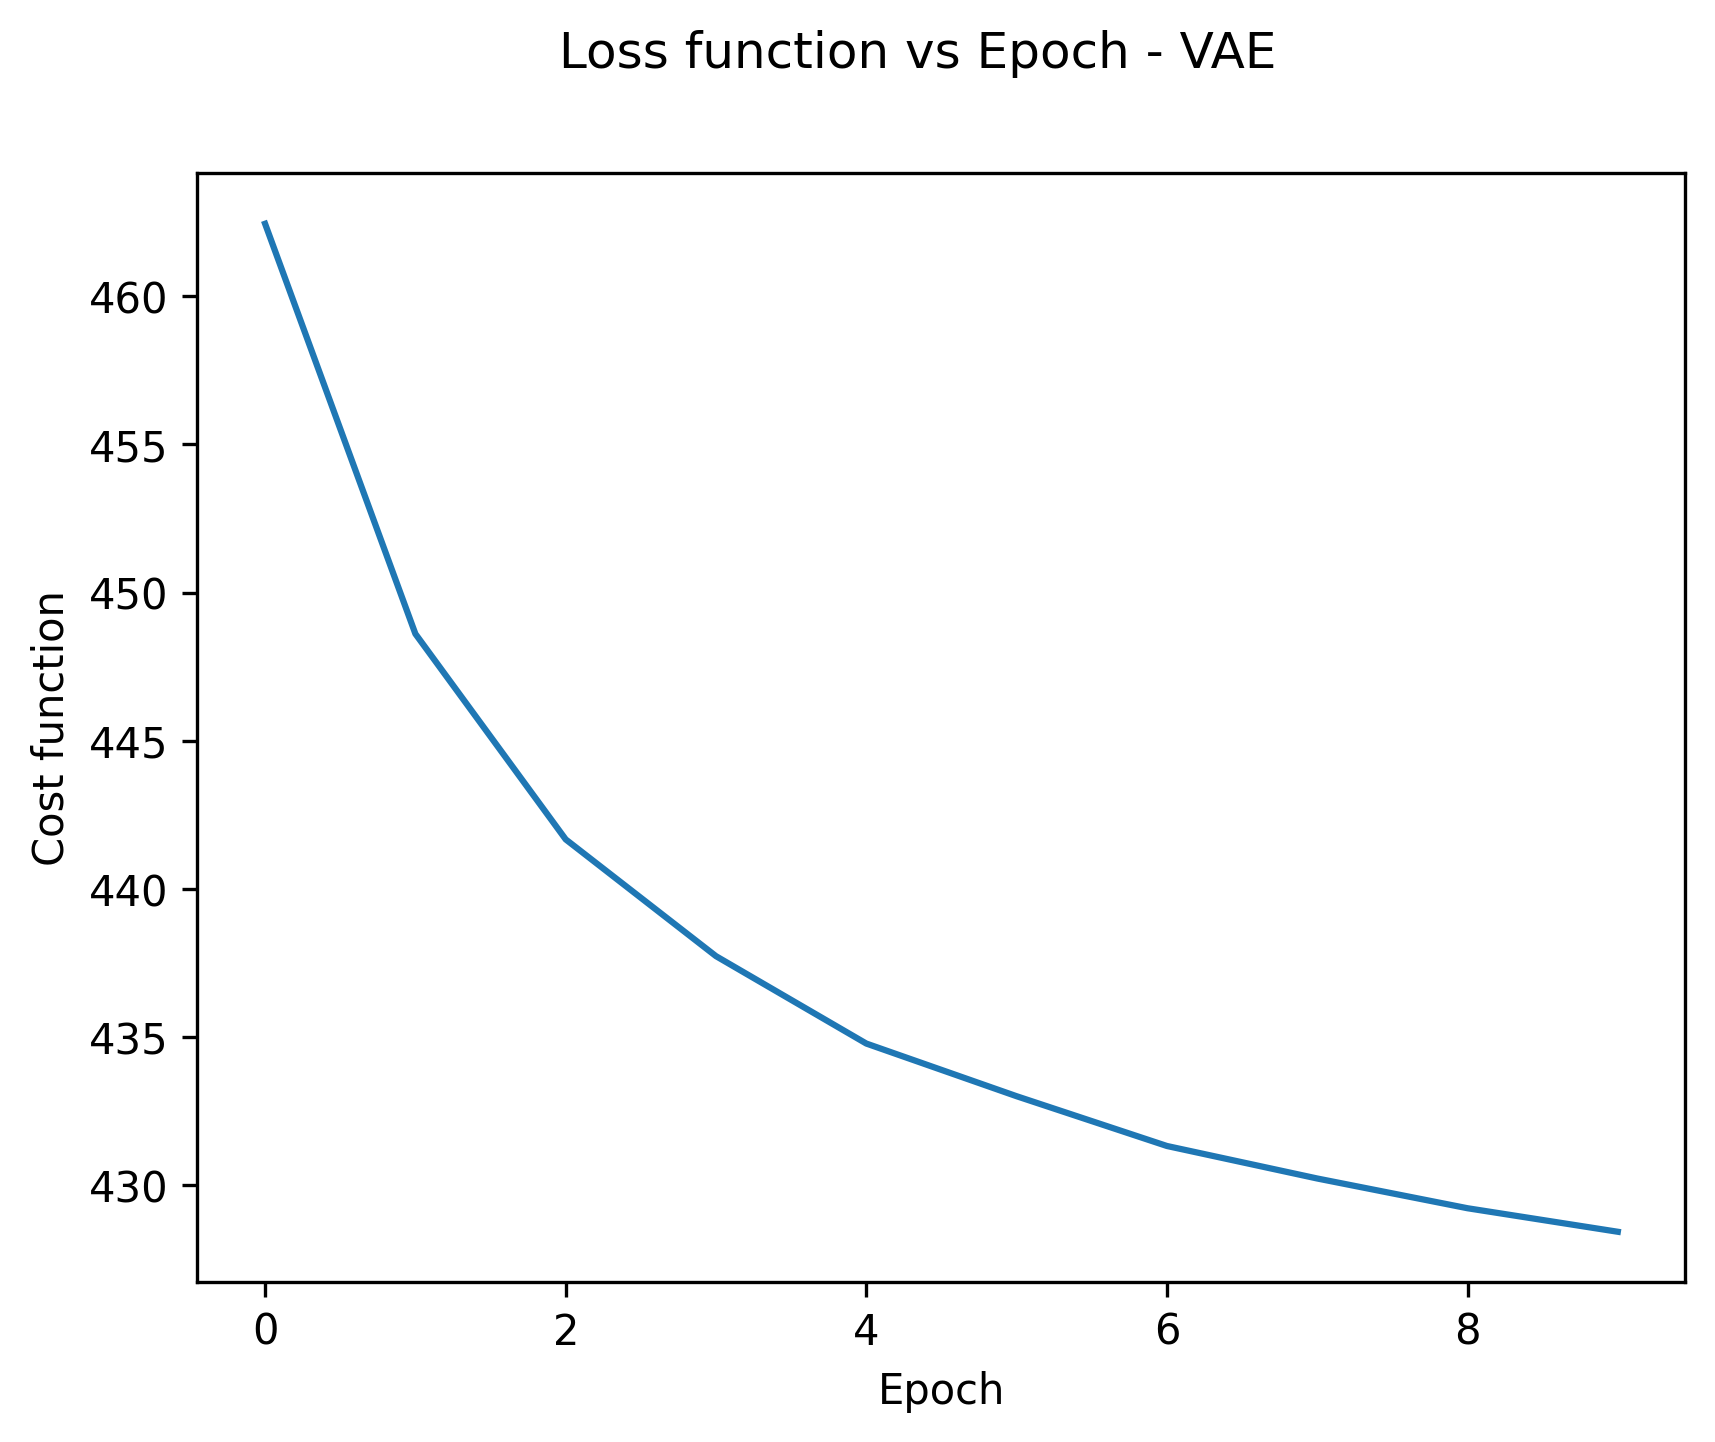

In [ ]:
train(
    temps = temps,
    batch_size = batch_size,
    epochs = epochs,
    latent_dim = latent_dim,
    num_examples_to_generate = num_examples_to_generate,
    test_size = 100,
)

## Refrence weights

In [ ]:
batch_size = 120
dataset_1 = dataset_tfrecord_pipeline(data_path / f"Data2.2.tfrecord", flatten=False, batch_size=int(batch_size/3))
dataset_2 = dataset_tfrecord_pipeline(data_path / f"Data2.0.tfrecord", flatten=False, batch_size=int(batch_size/3))
dataset_3 = dataset_tfrecord_pipeline(data_path / f"Data2.5.tfrecord", flatten=False, batch_size=int(batch_size/3))

def dataset_generator(dataset_1, dataset_2, dataset_3, temp_vectors):
  for image_batch_1, image_batch_2, image_batch_3 in zip(dataset_1, dataset_2, dataset_3):
    temp_vector = tf.concat(temp_vectors, axis = 0)
    image_batch = tf.concat((image_batch_1, image_batch_2, image_batch_3), axis = 0)
    yield image_batch, temp_vector

temp_vector_1 = np.zeros(shape = (int(batch_size/3), len(temps)))
temp_vector_1[0] = 1
temp_vector_2 = np.zeros(shape = (int(batch_size/3), len(temps)))
temp_vector_2[3] = 1
temp_vector_3 = np.zeros(shape = (int(batch_size/3), len(temps)))
temp_vector_3[6] = 1

gen = dataset_generator(dataset_1, dataset_2, dataset_3, (temp_vector_1, temp_vector_2, temp_vector_3))
dataset = tf.data.Dataset.from_generator(lambda: gen, output_signature = (tf.TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32), tf.TensorSpec(shape=(None, len(temps)), dtype=tf.float32)))


In [ ]:
train(
    temps = temps,
    batch_size = batch_size,
    epochs = 1,
    latent_dim = latent_dim,
    num_examples_to_generate = num_examples_to_generate,
    test_size = 100,
    dataset = dataset
)